In [110]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split

# Input dataset
data = pd.read_csv('/content/dataset_6.csv')

# Modify the "needed" column
needed_columns = ['needed_ban', 'needed_mesin', 'needed_bodi', 'needed_interior', 'needed_oli']
needed_values = data['needed'].apply(lambda x: [int(value == x) for value in ['ban', 'mesin', 'bodi', 'interior', 'oli']])
needed_df = pd.DataFrame(needed_values.tolist(), columns=needed_columns)
data_encoded = pd.concat([data, needed_df], axis=1)

# Modify the "covered" column
covered_columns = ['covered_ban', 'covered_mesin', 'covered_bodi', 'covered_interior', 'covered_oli']
covered_values = data['covered'].apply(lambda x: [int(value in x.split('|')) for value in ['ban', 'mesin', 'bodi', 'interior', 'oli']])
covered_df = pd.DataFrame(covered_values.tolist(), columns=covered_columns)
data_encoded = pd.concat([data_encoded, covered_df], axis=1)

# Convert ratings to integers
data_encoded['rating'] = data_encoded['rating'].astype(int)

# Remove 'needed' and 'covered' columns from the encoded DataFrame
data_encoded = data_encoded.drop(['needed', 'covered'], axis=1)

# Split data into training and testing sets
train_data, test_data = train_test_split(data_encoded, test_size=0.2, random_state=42)

# Separate features and target variables
train_features = train_data.drop(['technicians_id', 'rating'] + covered_columns, axis=1)
train_target = train_data[['technicians_id', 'rating'] + covered_columns]
test_features = test_data.drop(['technicians_id', 'rating'] + covered_columns, axis=1)
test_target = test_data[['technicians_id', 'rating'] + covered_columns]

# Convert the train features and target to float32
train_features = np.array(train_features).astype(np.float32)
train_target = np.array(train_target).astype(np.float32)

# Convert the test features and target to float32
test_features = np.array(test_features).astype(np.float32)
test_target = np.array(test_target).astype(np.float32)

# Define model
model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(train_features.shape[1],)))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.1)))
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(Dense(train_target.shape[1], activation='softmax'))

def mean_average_precision(y_true, y_pred):
    # Extract the relevant information from y_true and y_pred
    y_true = test_features
    y_pred = test_target
    user_id = y_true[:, 0]
    needed = y_true[:, 1:6]
    technicians_id = y_pred[:, 0]
    rating = y_pred[:, 1]
    covered = y_pred[:, 2:7]

    # Compute the Average Precision (AP) for each user
    ap_values = []
    for i in range(len(user_id)):
        # Get the relevant items for the user from y_true
        relevant_items = np.where(needed[i] == 1)[0]

        # Get the predicted items for the user from y_pred
        predicted_items = np.where(covered[i] == 1)[0]

        # Compute the precision at each position
        precision = []
        for j in range(len(predicted_items)):
            if predicted_items[j] in relevant_items:
                precision.append(np.sum(predicted_items[:j+1] == predicted_items[j]) / (j+1))

        # Compute the Average Precision (AP) for the user
        ap = np.mean(precision) if precision else 0.0
        ap_values.append(ap)

    # Compute the Mean Average Precision (MAP) across all users
    map_value = np.mean(ap_values)
    
    return map_value

# Compile model
model.compile(loss='hinge', optimizer= 'adam', metrics=[mean_average_precision])

# Train model
history = model.fit(train_features, train_target, epochs=30, validation_split=0.2, batch_size = 32)

# Evaluate the model
test_loss, test_map = model.evaluate(test_features, test_target)


Epoch 1/30
10/10 [==============================] - 2s 27ms/step - loss: 8.7229 - mean_average_precision: 0.8083 - val_loss: 7.9302 - val_mean_average_precision: 0.8083
Epoch 2/30
10/10 [==============================] - 0s 7ms/step - loss: 7.4823 - mean_average_precision: 0.8083 - val_loss: 6.8850 - val_mean_average_precision: 0.8083
Epoch 3/30
10/10 [==============================] - 0s 7ms/step - loss: 6.4303 - mean_average_precision: 0.8083 - val_loss: 5.9062 - val_mean_average_precision: 0.8083
Epoch 4/30
10/10 [==============================] - 0s 7ms/step - loss: 5.5161 - mean_average_precision: 0.8083 - val_loss: 5.0667 - val_mean_average_precision: 0.8083
Epoch 5/30
10/10 [==============================] - 0s 7ms/step - loss: 4.7344 - mean_average_precision: 0.8083 - val_loss: 4.3500 - val_mean_average_precision: 0.8083
Epoch 6/30
10/10 [==============================] - 0s 9ms/step - loss: 4.0684 - mean_average_precision: 0.8083 - val_loss: 3.7428 - val_mean_average_precision

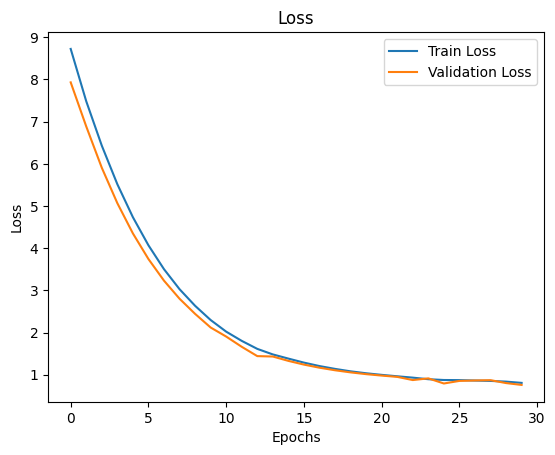

In [111]:
# Plot the loss and accuracy
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

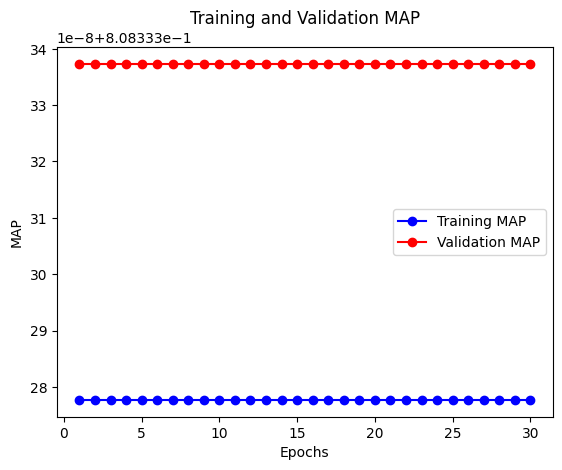

In [112]:
import matplotlib.pyplot as plt

# Get the MAP values for each epoch
train_map = history.history['mean_average_precision']
val_map = history.history['val_mean_average_precision']

# Plot the MAP values
epochs = range(1, len(train_map) + 1)
plt.plot(epochs, train_map, 'bo-', label='Training MAP')
plt.plot(epochs, val_map, 'ro-', label='Validation MAP')
plt.xlabel('Epochs')
plt.ylabel('MAP')
plt.title('Training and Validation MAP')
plt.legend()
plt.show()


In [113]:
# Preprocess the input
user_id = int(input("Enter User ID: "))
needed_ban = int(input("Ban needed (0/1): "))
needed_mesin = int(input("Mesin needed (0/1): "))
needed_bodi = int(input("Bodi needed (0/1): "))
needed_interior = int(input("Interior needed (0/1): "))
needed_oli = int(input("Oli needed (0/1): "))

# Encode the user's input
user_data = pd.DataFrame([[user_id, needed_ban, needed_mesin, needed_bodi, needed_interior, needed_oli]],
                         columns=['user_id', 'needed_ban', 'needed_mesin', 'needed_bodi', 'needed_interior', 'needed_oli'])

# Convert the user's encoded features to float32
user_features = np.array(user_data).astype(np.float32)

# Make predictions
predictions = model.predict(user_features)

# Retrieve the predicted technicians and ratings
predicted_technicians_id = predictions[0][0]
predicted_rating = predictions[0][1]
predicted_covered = predictions[0][2:]
predicted_technicians_id = int(np.round(np.clip(predicted_technicians_id, 1, 20)))
predicted_rating = int(np.round(np.clip(predicted_rating, 1, 5)))

# Convert the predicted_covered values to exact 1s and 0s
predicted_covered_exact = np.argmax(predicted_covered)

# Decode the one-hot encoded covered columns
covered_columns = ['covered_ban', 'covered_mesin', 'covered_bodi', 'covered_interior', 'covered_oli']
predicted_covered_dict = {}
for i in range(len(covered_columns)):
    predicted_covered_dict[covered_columns[i]] = int(predicted_covered_exact == i)

# Print the predicted results
print("Predicted Technicians ID:", predicted_technicians_id)
print("Predicted Rating:", predicted_rating)
print("Predicted Covered:")
for column, value in predicted_covered_dict.items():
  print(column + ":", int(value))

Enter User ID: 56
Ban needed (0/1): 0
Mesin needed (0/1): 0
Bodi needed (0/1): 0
Interior needed (0/1): 1
Oli needed (0/1): 0
1/1 [==============================] - 0s 64ms/step
Predicted Technicians ID: 1
Predicted Rating: 1
Predicted Covered:
covered_ban: 0
covered_mesin: 0
covered_bodi: 0
covered_interior: 0
covered_oli: 1


In [114]:
model.save("model.h5")

In [115]:
import tensorflow as tf

export_dir = 'saved_model/1'
tf.saved_model.save(model, export_dir)

# Convert model
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
tflite_model = converter.convert()

import pathlib

tflite_model_file = pathlib.Path('model.tflite')
tflite_model_file.write_bytes(tflite_model)

# Load TFLite model and allocate tensors
interpreter = tf.lite.Interpreter(model_content=tflite_model)
interpreter.allocate_tensors()

# Get input and output tensors
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

try:
    from google.colab import files
    files.download(tflite_model_file)
except:
    pass

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>